[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/lisuex/Machine-Learning2025/blob/main/Lab06.ipynb)

# **Research Questions**
**1) Are local RSS minimization and RSS gain maximization equivalent?**

Yes, both methods choose the treshold where Children RSS is minimalized.
Local RSS minimalization just minimalizes the Children RSS and RSS gain maximization maximises Parent RSS - Children RSS so effectively minimalizes Children RSS because Parent RSS is constant for each considered treshold.

**2) Does total RSS minimization coincide with either of these two, or is it distinct?**

Total RSS minimalization is different.
local RSS minimalization and RSS gain maximization are local methods which means they look only on the one node and data in this node.
Total RSS minimalization looks also at the other leaves, and RSS is calculated not only for two nodes, but for all leaves.
That means when the tree more then 2 leaves, the total RSS minimalization differs because the RSS is calculated on more data.


**Empirical Experiment**

In the following code I created example dataset with just 1 feature and calculate tresholds for tree degree 2: Local RSS Minimization, RSS Gain Maximization and Total RSS Minimization.

As I wrote before, when calculating treshold for first node, all methods are the same.
With the second layer they differ

Then, I calculated tresholds using DecisionTreeRegressor and plot the tree.
As we can see, the DecisionTreeRegressor has the same tresholds as Local RSS Minimization and RSS Gain Maximization.


=== Local RSS Tree ===
X[0] <= 5.50
  Left: X[0] <= 3.32
    Leaf: value=10.70
    Leaf: value=22.16
  Right: X[0] <= 7.14
    Leaf: value=31.58
    Leaf: value=43.07
Total RSS: 1110.72

=== RSS Gain Tree ===
X[0] <= 5.50
  Left: X[0] <= 3.32
    Leaf: value=10.70
    Leaf: value=22.16
  Right: X[0] <= 7.14
    Leaf: value=31.58
    Leaf: value=43.07
Total RSS: 1110.72

=== Total RSS Tree ===
X[0] <= 5.50
  Left: X[0] <= 1.77
    Leaf: value=6.74
    Leaf: value=18.28
  Right: X[0] <= 8.68
    Leaf: value=35.62
    Leaf: value=46.66
Total RSS: 2008.64

=== Scikit-learn Tree ===
Total RSS: 1110.72


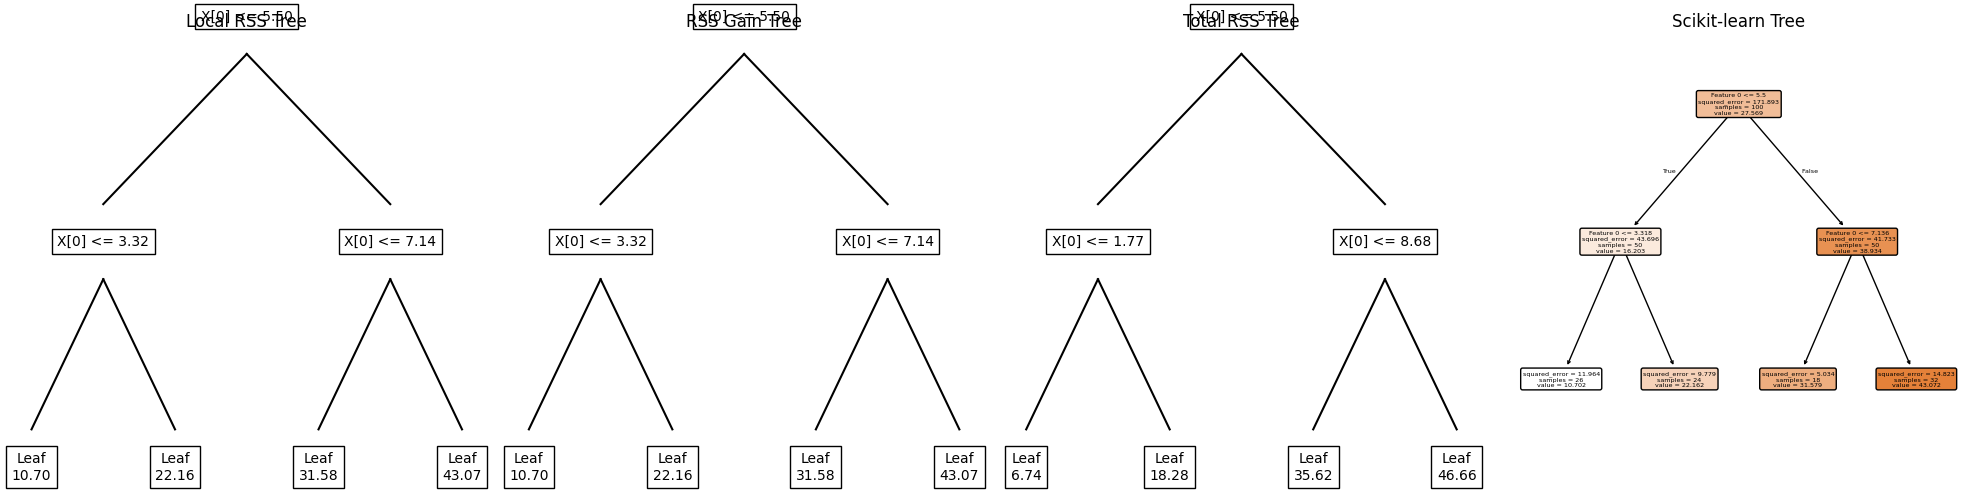


=== Structure Comparison ===
Local RSS Structure: ('Split_0_5.50', ('Split_1_3.32', 'Leaf_2', 'Leaf_2'), ('Split_1_7.14', 'Leaf_2', 'Leaf_2'))
RSS Gain Structure: ('Split_0_5.50', ('Split_1_3.32', 'Leaf_2', 'Leaf_2'), ('Split_1_7.14', 'Leaf_2', 'Leaf_2'))
Total RSS Structure: ('Split_0_5.50', ('Split_1_1.77', 'Leaf_2', 'Leaf_2'), ('Split_1_8.68', 'Leaf_2', 'Leaf_2'))
Scikit-learn Structure: ('Split_0_5.50', ('Split_1_3.32', 'Leaf_2', 'Leaf_2'), ('Split_1_7.14', 'Leaf_2', 'Leaf_2'))


In [49]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor, plot_tree

# Generate dataset
np.random.seed(42)
n_samples = 100
feature_0 = np.linspace(1.0, 10.0, n_samples)
np.random.shuffle(feature_0)
X = feature_0.reshape(-1, 1)  # Shape (100, 1)
y = 5 * feature_0 + np.random.normal(0, 1, n_samples)

# Utility functions
def is_pure(y):
    return len(np.unique(y)) == 1

def make_leaf(y):
    return {'value': np.mean(y), 'is_leaf': True}

def get_possible_splits(X):
    unique_values = np.unique(X[:, 0])
    return (unique_values[:-1] + unique_values[1:]) / 2

def compute_leaf_rss(y):
    if len(y) == 0:
        return 0
    return np.sum((y - np.mean(y))**2)

def compute_tree_rss(tree, X, y):
    if tree['is_leaf']:
        return np.sum((y - tree['value'])**2)
    left_indices = X[:, 0] <= tree['threshold']
    right_indices = ~left_indices
    return (compute_tree_rss(tree['left'], X[left_indices], y[left_indices]) +
            compute_tree_rss(tree['right'], X[right_indices], y[right_indices]))

# Method 1: Local RSS Minimization
def get_threshold_local_rss(X, y):
    best_threshold = None
    best_rss = float('inf')

    for threshold in get_possible_splits(X):
        left_indices = X[:, 0] <= threshold
        right_indices = ~left_indices

        if sum(left_indices) < 1 or sum(right_indices) < 1:
            continue

        left_rss = compute_leaf_rss(y[left_indices])
        right_rss = compute_leaf_rss(y[right_indices])
        total_rss = left_rss + right_rss

        if total_rss < best_rss:
            best_rss = total_rss
            best_threshold = threshold

    return best_threshold, best_rss

# Method 2: RSS Gain Maximization
def get_threshold_rss_gain(X, y):
    best_threshold = None
    best_gain = -1
    parent_rss = compute_leaf_rss(y)

    for threshold in get_possible_splits(X):
        left_indices = X[:, 0] <= threshold
        right_indices = ~left_indices

        if sum(left_indices) < 1 or sum(right_indices) < 1:
            continue

        left_rss = compute_leaf_rss(y[left_indices])
        right_rss = compute_leaf_rss(y[right_indices])
        gain = parent_rss - (left_rss + right_rss)

        if gain > best_gain:
            best_gain = gain
            best_threshold = threshold

    return best_threshold, parent_rss - best_gain

# Method 3: Total RSS Minimization
def get_threshold_total_rss(X, y, feature0_threshold=None):
    if feature0_threshold is None:
        return get_threshold_local_rss(X, y)  # Greedy for root
    else:
        best_threshold = None
        best_total_rss = float('inf')

        leaf1_indices = X[:, 0] <= feature0_threshold
        leaf2_indices = ~leaf1_indices

        if sum(leaf1_indices) < 2 or sum(leaf2_indices) < 2:
            print("Insufficient points in leaves")
            return None, float('inf')

        for threshold in get_possible_splits(X):
            leaf1_left = leaf1_indices & (X[:, 0] <= threshold)
            leaf1_right = leaf1_indices & (X[:, 0] > threshold)
            leaf2_left = leaf2_indices & (X[:, 0] <= threshold)
            leaf2_right = leaf2_indices & (X[:, 0] > threshold)

            if (sum(leaf1_left) + sum(leaf1_right) < 1) or (sum(leaf2_left) + sum(leaf2_right) < 1):
                continue

            rss1 = compute_leaf_rss(y[leaf1_left])
            rss2 = compute_leaf_rss(y[leaf1_right])
            rss3 = compute_leaf_rss(y[leaf2_left])
            rss4 = compute_leaf_rss(y[leaf2_right])
            total_rss = rss1 + rss2 + rss3 + rss4

            if total_rss < best_total_rss:
                best_total_rss = total_rss
                best_threshold = threshold

        if best_threshold is None:
            best_threshold = get_possible_splits(X)[0]
            left_indices = X[:, 0] <= best_threshold
            right_indices = ~left_indices
            best_total_rss = compute_leaf_rss(y[left_indices]) + compute_leaf_rss(y[right_indices])

        return best_threshold, best_total_rss

# Tree building functions
def build_tree_local_rss(X, y, depth=0, max_depth=2, min_samples_split=2):
    if depth == max_depth or len(y) < min_samples_split or is_pure(y):
        return make_leaf(y)

    threshold, _ = get_threshold_local_rss(X, y)
    if threshold is None:
        return make_leaf(y)

    left_indices = X[:, 0] <= threshold
    right_indices = ~left_indices

    left_subtree = build_tree_local_rss(
        X[left_indices], y[left_indices], depth+1, max_depth, min_samples_split
    )
    right_subtree = build_tree_local_rss(
        X[right_indices], y[right_indices], depth+1, max_depth, min_samples_split
    )

    return {
        'threshold': threshold,
        'left': left_subtree,
        'right': right_subtree,
        'is_leaf': False
    }

def build_tree_rss_gain(X, y, depth=0, max_depth=2, min_samples_split=2):
    if depth == max_depth or len(y) < min_samples_split or is_pure(y):
        return make_leaf(y)

    threshold, _ = get_threshold_rss_gain(X, y)
    if threshold is None:
        return make_leaf(y)

    left_indices = X[:, 0] <= threshold
    right_indices = ~left_indices

    left_subtree = build_tree_rss_gain(
        X[left_indices], y[left_indices], depth+1, max_depth, min_samples_split
    )
    right_subtree = build_tree_rss_gain(
        X[right_indices], y[right_indices], depth+1, max_depth, min_samples_split
    )

    return {
        'threshold': threshold,
        'left': left_subtree,
        'right': right_subtree,
        'is_leaf': False
    }

def build_tree_total_rss(X, y, depth=0, max_depth=2, min_samples_split=2):
    if depth == max_depth or len(y) < min_samples_split or is_pure(y):
        return make_leaf(y)

    if depth == 0:
        threshold, _ = get_threshold_total_rss(X, y)
    elif depth == 1:
        # calculate threshold0 and based on that, calculate tresholds for next layers
        threshold0, _ = get_threshold_total_rss(X, y)
        threshold, _ = get_threshold_total_rss(X, y, feature0_threshold=threshold0)
    else:
      # we make only depth 2
      threshold is None

    if threshold is None:
        return make_leaf(y)

    left_indices = X[:, 0] <= threshold
    right_indices = ~left_indices

    left_subtree = build_tree_total_rss(
        X[left_indices], y[left_indices], depth+1, max_depth, min_samples_split
    )
    right_subtree = build_tree_total_rss(
        X[right_indices], y[right_indices], depth+1, max_depth, min_samples_split
    )

    return {
        'threshold': threshold,
        'left': left_subtree,
        'right': right_subtree,
        'is_leaf': False
    }

# Print custom tree
def print_tree(tree, indent="", name=""):
    if tree['is_leaf']:
        print(f"{indent}Leaf: value={tree['value']:.2f}")
    else:
        print(f"{indent}{name}X[0] <= {tree['threshold']:.2f}")
        print_tree(tree['left'], indent + "  ", "Left: ")
        print_tree(tree['right'], indent + "  ", "Right: ")

# Plot custom tree
def plot_custom_tree(tree, ax, x=0.5, y=1.0, depth=0, width=0.4, max_depth=2):
    if tree['is_leaf']:
        ax.text(x, y, f"Leaf\n{tree['value']:.2f}", ha='center', va='center',
                bbox=dict(facecolor='white', edgecolor='black'))
        return

    ax.text(x, y, f"X[0] <= {tree['threshold']:.2f}",
            ha='center', va='center', bbox=dict(facecolor='white', edgecolor='black'))

    if depth < max_depth:
        left_x = x - width / (2 ** (depth + 1))
        right_x = x + width / (2 ** (depth + 1))
        next_y = y - 0.3

        ax.plot([x, left_x], [y - 0.05, next_y + 0.05], 'k-')
        ax.plot([x, right_x], [y - 0.05, next_y + 0.05], 'k-')

        plot_custom_tree(tree['left'], ax, left_x, next_y, depth + 1, width, max_depth)
        plot_custom_tree(tree['right'], ax, right_x, next_y, depth + 1, width, max_depth)

# Experiment
def run_experiment(X, y, max_depth=2):
    # Build trees
    local_tree = build_tree_local_rss(X, y, max_depth=max_depth)
    gain_tree = build_tree_rss_gain(X, y, max_depth=max_depth)
    total_tree = build_tree_total_rss(X, y, max_depth=max_depth)
    sklearn_tree = DecisionTreeRegressor(max_depth=max_depth, min_samples_split=2,
                                        criterion='squared_error', random_state=42)
    sklearn_tree.fit(X, y)

    # Compute RSS
    local_rss = compute_tree_rss(local_tree, X, y)
    gain_rss = compute_tree_rss(gain_tree, X, y)
    total_rss = compute_tree_rss(total_tree, X, y)
    sklearn_rss = np.sum((y - sklearn_tree.predict(X))**2)

    # Print trees
    print("\n=== Local RSS Tree ===")
    print_tree(local_tree)
    print(f"Total RSS: {local_rss:.2f}")

    print("\n=== RSS Gain Tree ===")
    print_tree(gain_tree)
    print(f"Total RSS: {gain_rss:.2f}")

    print("\n=== Total RSS Tree ===")
    print_tree(total_tree)
    print(f"Total RSS: {total_rss:.2f}")

    print("\n=== Scikit-learn Tree ===")
    print(f"Total RSS: {sklearn_rss:.2f}")

    # Plot trees
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(20, 5))

    # Local RSS
    plot_custom_tree(local_tree, ax1, max_depth=max_depth)
    ax1.set_title("Local RSS Tree")
    ax1.axis('off')

    # RSS Gain
    plot_custom_tree(gain_tree, ax2, max_depth=max_depth)
    ax2.set_title("RSS Gain Tree")
    ax2.axis('off')

    # Total RSS
    plot_custom_tree(total_tree, ax3, max_depth=max_depth)
    ax3.set_title("Total RSS Tree")
    ax3.axis('off')

    # Scikit-learn tree
    plot_tree(sklearn_tree, ax=ax4, feature_names=['Feature 0'],
              filled=True, rounded=True)
    ax4.set_title("Scikit-learn Tree")

    plt.tight_layout()
    plt.show()

    # Compare structures
    print("\n=== Structure Comparison ===")
    def get_structure(tree, depth=0):
        if tree['is_leaf']:
            return f"Leaf_{depth}"
        return (f"Split_{depth}_{tree['threshold']:.2f}",
                get_structure(tree['left'], depth+1),
                get_structure(tree['right'], depth+1))

    local_structure = get_structure(local_tree)
    gain_structure = get_structure(gain_tree)
    total_structure = get_structure(total_tree)

    tree_ = sklearn_tree.tree_
    def get_sklearn_structure(node=0, depth=0):
        if tree_.children_left[node] == -1:
            return f"Leaf_{depth}"
        feature = tree_.feature[node]
        threshold = tree_.threshold[node]
        left = get_sklearn_structure(tree_.children_left[node], depth+1)
        right = get_sklearn_structure(tree_.children_right[node], depth+1)
        return f"Split_{depth}_{threshold:.2f}", left, right

    sklearn_structure = get_sklearn_structure()

    print("Local RSS Structure:", local_structure)
    print("RSS Gain Structure:", gain_structure)
    print("Total RSS Structure:", total_structure)
    print("Scikit-learn Structure:", sklearn_structure)

# Run experiment
run_experiment(X, y, max_depth=2)

(Sorry for some chaos in code)


As we can see in the plots, the Local RSS Tree and RSS Gain Tree are the same as expected.

Total RSS Tree is different (also as expected) while first treshold is the same and on next layers they differ (I wrote about it at the begging)

Scikit-learn Tree has the same tresholds as Tree made using Local RSS and RSS Gain so that suggests that scikit-learn tree uses this method for calculating tresholds.

Detailed values are presented with "Structure Comparison" where wee can see that tresholds are the same with first two methos and the method used by scikit-learn